<a href="https://colab.research.google.com/github/santhoshkammari/BURGER-BULDER/blob/main/Copy_of_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real and Fake Face detection
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [1]:
!git clone https://github.com/SkyThonk/real-and-fake-face-detection

Cloning into 'real-and-fake-face-detection'...
remote: Enumerating objects: 2074, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2074 (delta 1), reused 0 (delta 0), pack-reused 2068
Receiving objects: 100% (2074/2074), 278.04 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Dataset

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [4]:
nbatch = 64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/real-and-fake-face-detection/dataset/training',
                                                 target_size=(128,128),
                                                 batch_size = nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/real-and-fake-face-detection/dataset/test',
                                            target_size=(128,128),
                                            batch_size = nbatch,
                                            class_mode = 'binary')

Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


Text(0.5, 0, 'Class')

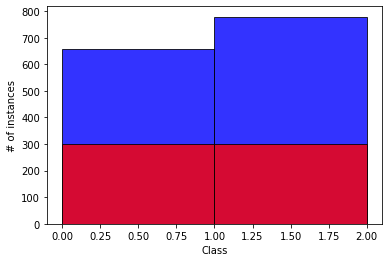

In [5]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(64, 128, 128, 3) (64,)


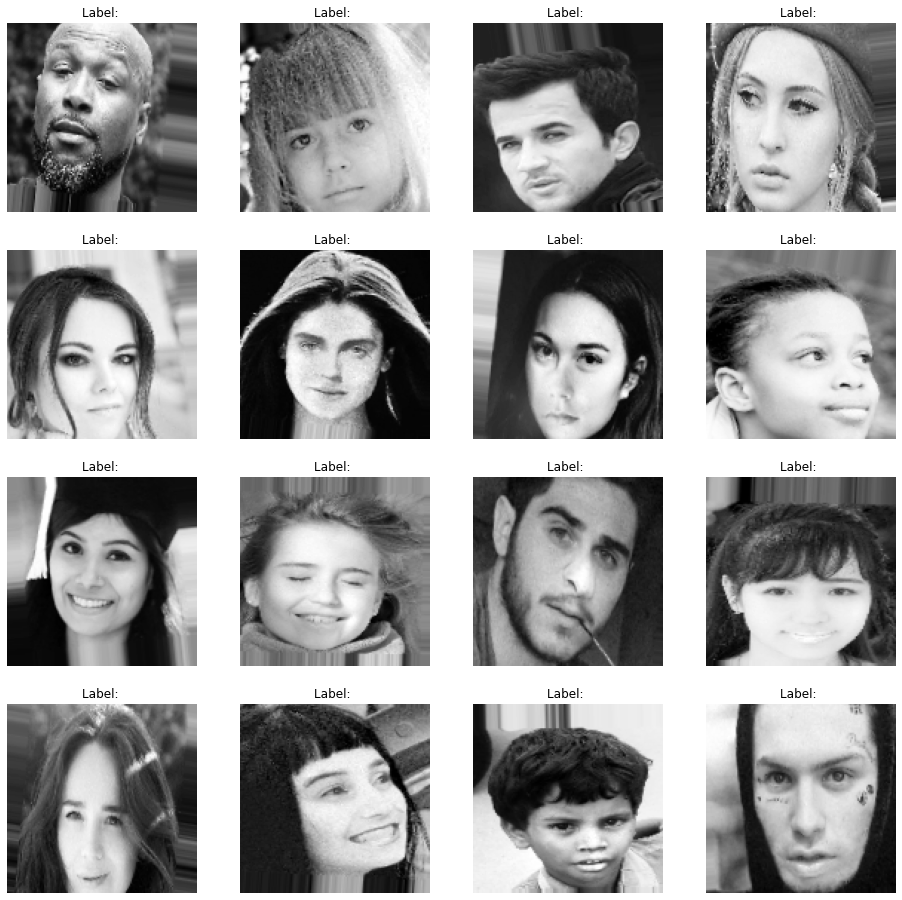

In [6]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

##### Compile the model

In [8]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [9]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode ='max'),
]

In [10]:
print(1437//64)
604//64

22


9

In [11]:
history = model.fit(
        training_set,
        steps_per_epoch=22,
        epochs=10,
        validation_data=test_set,
        validation_steps=9,
        callbacks = callbacks_list
    )

Epoch 1/10
22/22 [==============================] - 59s 1s/step - loss: 0.7884 - accuracy: 0.5368 - val_loss: 0.6922 - val_accuracy: 0.5017
Epoch 2/10
22/22 [==============================] - 28s 1s/step - loss: 0.6907 - accuracy: 0.5477 - val_loss: 0.6953 - val_accuracy: 0.5017
Epoch 3/10
22/22 [==============================] - 28s 1s/step - loss: 0.6900 - accuracy: 0.5441 - val_loss: 0.6885 - val_accuracy: 0.5087
Epoch 4/10
22/22 [==============================] - 28s 1s/step - loss: 0.6896 - accuracy: 0.5492 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 5/10
22/22 [==============================] - 27s 1s/step - loss: 0.6902 - accuracy: 0.5484 - val_loss: 0.6924 - val_accuracy: 0.4983
Epoch 6/10
22/22 [==============================] - 27s 1s/step - loss: 0.6882 - accuracy: 0.5470 - val_loss: 0.6859 - val_accuracy: 0.6267
Epoch 7/10
22/22 [==============================] - 27s 1s/step - loss: 0.6885 - accuracy: 0.5317 - val_loss: 0.6887 - val_accuracy: 0.5139
Epoch 8/10
22/22 [==

In [12]:
training_set.class_indices

{'fake': 0, 'real': 1}

Text(0.5, 0, '# of epochs')

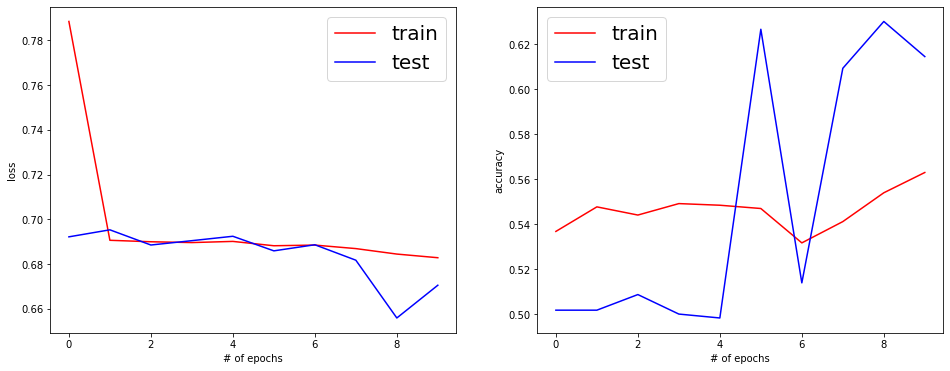

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [15]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

In [16]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict: 


FileNotFoundError: ignored

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

In [17]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

Enter Location of Image to predict: 


FileNotFoundError: ignored

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.